In [3]:
%cd ..
# to be in music-parameters-estimation 

/home/pcallens/room-acoustics-characterization


In [4]:
# Load various imports 
import pandas as pd
import os
import librosa
import glob
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

import pickle

from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from keras.models import load_model
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
import datetime

from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import Sequential
from datetime import datetime

from scipy import stats, signal
import acoustics
from acoustics.signal import bandpass
from acoustics.bands import (_check_band_type, octave_low, octave_high, third_low, third_high)

#from keras.callbacks import TensorBoard
from time import time
from argparse import ArgumentParser

from subprocess import call

# Custom imports
from utils.models import *

import pandas as pd
from progressbar import progressbar

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


Using TensorFlow backend.


## 1/ Test with convolved dataset

In [138]:
work_dir = 'datasets/final_ds/'

rir_test_dir = 'datasets/ACE_adapted/RIR/'
audio_test_dir = 'datasets/ACE_adapted/speech/'
true_acoustic_values_dir = 'datasets/ACE_adapted/true_acoustic_values_final/' #+ os.path.split(os.path.dirname(rir_test_dir))[1] + '/'
mfcc_dir = 'datasets/ACE_adapted/mfcc_8s/0db/mfcc/'


In [5]:
rir_normed_dir = rir_test_dir.strip('/') + '_sr16000_c_1/'


### Compute true values

### Run convolutions and compute mfcc

In [5]:
audio_duration = 15

call('python convolute.py -audioDir ' + audio_test_dir + 
     ' -rirDir ' + rir_test_dir + 
     ' -outDir ' + mfcc_dir + 
     ' -trim ' + str(audio_duration) +
     ' -outFormat mfcc', shell=True)

0

In [6]:

call('python acoustic_param_ds_maker.py -rirDir ' + rir_normed_dir + 
     ' -outDir ' + true_acoustic_values_dir + 
     ' -params all', shell=True)

0

In [8]:
#replace t60 with the old one with 12 outputs
call('python acoustic_param_ds_maker.py -rirDir ' + rir_normed_dir + 
     ' -outDir ' + 'datasets/final_ds/Test/acoustic_values_final/' + 
     ' -params c50 -bands 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300', shell=True)

0

### Visualize mfcc inputs

In [ ]:
import matplotlib.pyplot as plt
from librosa import display 

with open('datasets/thesis/train/speech/mfcc_0dB/0_5UnderpassValencia/speech-librivox-0007.pkl','rb') as f:
    mfcc = pickle.load(f)
f.close()

sr = 16000
plt.figure(figsize=(40, 16))
librosa.display.specshow(mfcc[:,:], sr=sr, hop_length= int(0.01*sr), 
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Reverberant audio input mfcc')
plt.tight_layout()
plt.show()


In [11]:
mfcc.shape

(40, 1500)

### Visualize target output

In [ ]:
with open('datasets/ACE_adapted/acoustic_values/t60/Meeting_Room_2_1.pkl','rb') as f:
    t60 = pickle.load(f)
f.close()
plt.plot(t60)

# Load model, predict and evaluate

#### 1. Define model

In [6]:
params = {'window_size': 798,
              'mfcc_bands': 40,
              'n_channels': 1,
              'output_size': 6}

model  = CRNN2D_largefilters((None,params['mfcc_bands'], 
                 params['window_size'],
                 params['n_channels']), 
                params['output_size'])

In [7]:
model.load_weights("thesis_trainings/weights/weights.best.t60_speech_mfcc_randdb_unbalanced.hdf5")
model.compile(loss='mean_squared_error')

#### 2. Make predictions

In [8]:


def predict(mfcc_dir,true_ac_dir,params):
    df = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(mfcc_dir + next(os.walk(mfcc_dir))[1][0]))[2])

    for room in progressbar(df.columns):
        for track in df.index:
            with open(os.path.join(mfcc_dir,room,track),'rb') as f:
                X = pickle.load(f)
            f.close()

            df.loc[track,room] = model.predict(X.reshape((1,params['mfcc_bands'], 
                                                          params['window_size'],
                                                          params['n_channels'])))
            
    return df

In [12]:

ac_param = 't60'
audio = 'speech'
noise = '0db'
out_dir = os.path.join('results','ACE',ac_param+'_'+audio,noise)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
mfcc_dir = 'datasets/ACE_adapted/mfcc_8s/0db/mfcc/'
true_acoustic_values_dir = 'datasets/ACE_adapted/acoustic_values/'

In [10]:
preds_df = predict(mfcc_dir,true_acoustic_values_dir,params)

100% (14 of 14) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


In [13]:
with open(os.path.join(out_dir,'preds_df.pkl'),'wb') as f:
    pickle.dump(preds_df,f)

#### 3. Make target dataframe

In [139]:
target_df = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(true_acoustic_values_dir))[1])


In [140]:
for param in target_df.index:
    for room in target_df.columns:
        with open(os.path.join(true_acoustic_values_dir,param,room) + '.pkl','rb') as f:
            true_val = pickle.load(f)
            target_df.loc[param,room] = true_val
        f.close()

In [141]:
with open(os.path.join(out_dir,'target_df.pkl'),'wb') as f:
    pickle.dump(target_df,f)

#### 4. Plot

#### 5. Compute error

In [17]:
import pandas as pd

In [18]:
#FOR 'ALL' params
error = []
res_arr = np.empty(len(preds_df))
for i,col in enumerate(preds_df.columns):
    preds_arr = np.vstack(preds_df[str(col)].values)
    t60 = target_df[str(col)].t60.mean()
    c50 = target_df[str(col)].c50.mean()
    c80 = target_df[str(col)].c80.mean()
    drr = target_df[str(col)].drr.mean()
    true_arr = np.hstack((t60,c50,c80,drr))

    
    
    error.append(100*(preds_df[str(col)].mean().squeeze()-true_arr)/true_arr)
    
er_df = pd.DataFrame(error,columns=['t60','c50','c80','drr'])

temptitle = os.path.split(out_dir)
temptitle2 = os.path.split(temptitle[0])
title = temptitle2[1] + '-' +  temptitle[1] + '_noise'

bands = acoustics.bands.octave(100,7000)

fig, ax = plt.subplots()
plt.title(title)
er_df.boxplot(color={'medians': 'blue'})
ax.set_ylim(-200,200)
plt.savefig(os.path.join(out_dir,'err_plot.png'))

ValueError: operands could not be broadcast together with shapes (6,) (4,) 

In [19]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [20]:
res_arr = np.empty(len(preds_df))
for i,col in enumerate(preds_df.columns):
    preds_arr = np.vstack(preds_df[str(col)].values)
    target_arr = np.vstack(len(preds_arr)*[(target_df[str(col)].t60)])
    res_arr[i] = mean_absolute_error(target_arr,preds_arr)
    

In [21]:
def compute_error_percent_perband(param):
    error = []#np.empty(size)
    #error_abs = np.empty(size)

    for i in range(len(preds_df.columns)):
        #error_abs[i] = 100*abs((target_df.T.eval(param)[i]-preds_df.mean()[i])/target_df.T.eval(param)[i])
        error.append(100*(preds_df.iloc(axis=1)[i].mean().squeeze()-target_df.T.eval(param)[i])/target_df.T.eval(param)[i])
    return np.array(error)

In [22]:
error_per_bands = compute_error_percent_perband(ac_param)

In [23]:
import pandas as pd
er_df = pd.DataFrame(error_per_bands,columns=[125, 250, 500, 1000, 2000, 4000])


In [24]:
temptitle = os.path.split(out_dir)
temptitle2 = os.path.split(temptitle[0])
title = temptitle2[1] + '-' +  temptitle[1] + '_noise'
title

't60_speech-0db_noise'

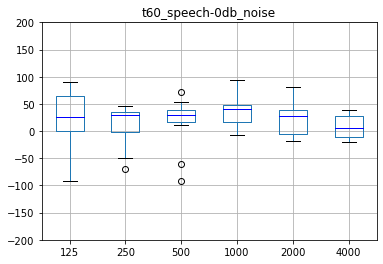

In [25]:
bands = acoustics.bands.octave(100,7000)

fig, ax = plt.subplots()
plt.title(title)
er_df.boxplot(color={'medians': 'blue'})
ax.set_ylim(-200,200)
plt.savefig(os.path.join(out_dir,'err_plot.png'))

In [26]:
y_pred = np.array([preds_df.iloc(axis=1)[i].mean().squeeze() for i in range(len(preds_df.columns))])
y_true =  np.array([target_df.T.eval(ac_param)[i] for i in range(len(preds_df.columns))])

In [27]:
np.save(os.path.join(out_dir,'y_true'),y_true)
np.save(os.path.join(out_dir,'y_pred'),y_pred)

In [28]:
import seaborn


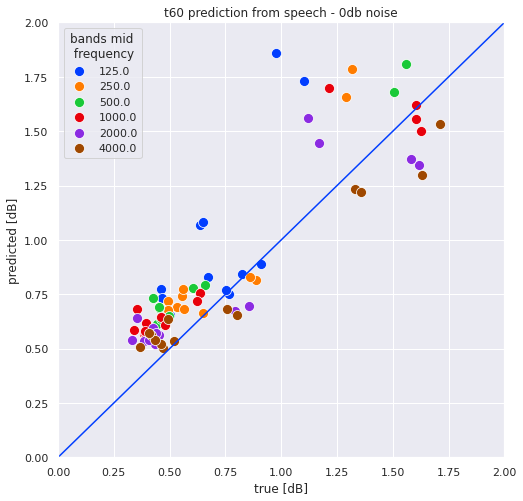

In [34]:



fig, ax = plt.subplots(figsize=(8,8))
bands = acoustics.bands.octave(100,7000)
seaborn.set(palette=seaborn.color_palette("bright",6))

ax.set_xlim(0,2)
ax.set_ylim(0,2)
for i in range(6):
    seaborn.scatterplot(y_true[:,i],y_pred[:,i], s= 100)

plt.title(ac_param + ' prediction from '+audio+' - '+noise+' noise')
plt.xlabel('true [dB]')
plt.ylabel('predicted [dB]')
plt.legend(bands, title = 'bands mid\n frequency')

seaborn.lineplot([-30,100],[-30,100], palette = seaborn.color_palette("dark"))



plt.savefig(os.path.join(out_dir,'scatterplt.png'))

## LOAD PREDS

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
with open('results/OLD_CRAP/t60_speech_1/0db/preds_df.pkl','rb') as f:
    preds_df = pickle.load(f).applymap(lambda x: x.squeeze())
f.close
with open('results/t60_speech/0db/target_df.pkl','rb') as f:
    target_df = pickle.load(f)
f.close

<function BufferedReader.close>

### COMPUTE ERROR

In [11]:
err = []
for room in preds_df.columns:
    for audio in preds_df.T:
        target = target_df.T.t60.loc[room]
        pred = preds_df.loc[audio,room]
        err.append(pred-target)


In [12]:
err_df = pd.DataFrame(np.array(err), columns=[125, 250, 500, 1000, 2000, 4000])

[Text(0, 0.5, 'Error [s]'),
 Text(0.5, 0, 'Frequency band'),
 Text(0.5, 1.0, 'Error on estimation from speech - 0dB noise SNR ')]

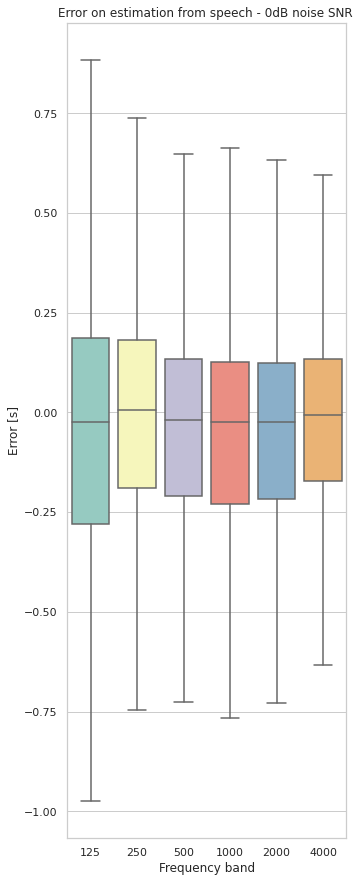

In [13]:
plt.figure(figsize=(5,15))
sns.set(style="whitegrid")
sns.set_style({'axes.grid': True})
ax = sns.boxplot(data=err_df,palette="Set3",saturation=0.75,showfliers=False)
ax.set(xlabel='Frequency band', ylabel='Error [s]', title = 'Error on estimation from speech - 0dB noise SNR ')

In [14]:
print('Root mean square error')
bands = [125, 250, 500, 1000, 2000, 4000]
for i in range(6):
    print(bands[i],np.sqrt(np.sum(np.array(err)[:,i]**2)/len(err)))

Root mean square error
125 0.8304174638305636
250 0.5129135570916526
500 0.4992544275608171
1000 0.5215489898147386
2000 0.49736458026587277
4000 0.5600111150758891


In [15]:
print('RMSE')
flat_err_squared = np.array(err).flatten() ** 2
np.sqrt(np.sum(np.array(flat_err_squared))/len(flat_err_squared))

RMSE


0.582369554522819

#### COMPUTE ERROR PERCENT

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [17]:
err_rel = []
pred_ = []
targ_ = []
for room in preds_df.columns:
    for audio in preds_df.T:
        target = target_df.T.t60.loc[room]
        pred = preds_df.loc[audio,room]
        err_rel.append(100*((pred-target)/target))
        pred_.append(pred)
        targ_.append(target)

In [23]:
MSE = mean_squared_error(targ_,pred_)

In [24]:
MAE = mean_absolute_error(targ_,pred_)

In [25]:
MAPE = mean_absolute_percentage_error(targ_,pred_)

In [26]:
RMSE = root_mean_squared_error(targ_,pred_)

In [28]:
err_file = np.array((['MSE','MAE','MAPE','RMSE'],[MSE,MAE,MAPE,RMSE]))

array([['MSE', 'MAE', 'MAPE', 'RMSE'],
       ['0.3391542980351052', '0.33258952977037504', '67.59920260197808',
        '0.5823695545228178']], dtype='<U19')

In [249]:
print('Percent mean square error')
bands = [125, 250, 500, 1000, 2000, 4000]
for i in range(6):
    print(bands[i],np.sqrt(np.sum(np.array(err_rel)[:,i]**2)/len(err_rel)))

Percent mean square error
125 99.60745095889044
250 139.25168624873646
500 127.69533947980227
1000 164.3042412691973
2000 221.96080357230784
4000 227.07688289387696


In [250]:
print('MAPE')
flat = (np.array(err_rel).flatten())
np.sum(np.abs(flat))/len(flat)

MAPE


67.59920260197808

In [251]:
print('RMAPE')


flat_err_squared = np.array(err_rel).flatten() ** 2
np.sqrt(np.sum(np.array(flat_err_squared))/len(flat_err_squared))

RMAPE


170.02214017631985

In [252]:
err_df_pc = pd.DataFrame(np.array(err_rel), columns=[125, 250, 500, 1000, 2000, 4000])

[Text(0, 0.5, 'MAPE [%]'),
 Text(0.5, 0, 'Frequency band'),
 Text(0.5, 1.0, 'MAPE Error on estimation from speech - 0dB noise SNR ')]

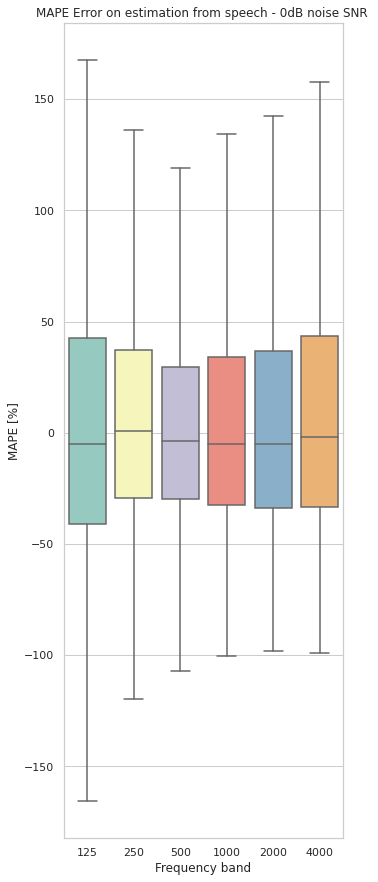

In [253]:
plt.figure(figsize=(5,15))
sns.set(style="whitegrid")
sns.set_style({'axes.grid': True})
ax = sns.boxplot(data=err_df_pc,palette="Set3",saturation=0.75,showfliers=False)
ax.set(xlabel='Frequency band', ylabel='MAPE [%]', title = 'MAPE Error on estimation from speech - 0dB noise SNR ')

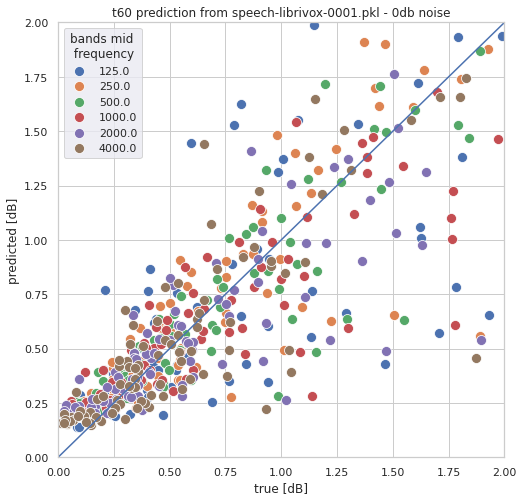

In [254]:
y_pred = np.array([preds_df.iloc(axis=1)[i].mean().squeeze() for i in range(len(preds_df.columns))])
y_true =  np.array([target_df.T.eval(ac_param)[i] for i in range(len(preds_df.columns))])


fig, ax = plt.subplots(figsize=(8,8))
bands = acoustics.bands.octave(100,7000)
seaborn.set(palette=seaborn.color_palette("bright",6))

ax.set_xlim(0,2)
ax.set_ylim(0,2)
for i in range(6):
    seaborn.scatterplot(y_true[:,i],y_pred[:,i], s= 100)

plt.title(ac_param+ ' prediction from '+audio+' - '+noise+' noise')
plt.xlabel('true [dB]')
plt.ylabel('predicted [dB]')
plt.legend(bands, title = 'bands mid\n frequency')

seaborn.lineplot([-30,100],[-30,100], palette = seaborn.color_palette("dark"))



plt.savefig(os.path.join(out_dir,'scatterplt.png'))

In [59]:
test = 

In [60]:
test

,Office_2_2,Meeting_Room_1_1,Lecture_Room_1_2,Building_Lobby_1,Building_Lobby_2,Meeting_Room_1_2,Office_1_2,Meeting_Room_2_2,Lecture_Room_2_1,Lecture_Room_1_1,Meeting_Room_2_1,Office_1_1,Office_2_1,Lecture_Room_2_2
drr,-4.896716,-3.081464,-4.974588,-0.237434,-4.898135,-4.840044,-5.115444,0.99044,0.375344,2.57111,-1.115386,-2.170339,-2.535261,-4.536922
t60,0.390000,0.440000,0.640000,0.650000,0.650000,0.440000,0.340000,0.37000,1.250000,0.64000,0.370000,0.340000,0.390000,1.250000


In [67]:
err = []
col = 'h066_MITCampus_StudentLounge_2txts'
for pred in preds_df.T.loc[col]:
    err.append(pred-target_df.T.t60[col])

In [68]:
err = pd.DataFrame(np.array(err),columns=[125, 250, 500, 1000, 2000, 4000])

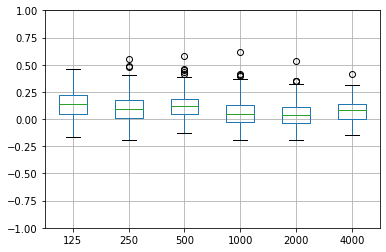

In [71]:

fig, ax = plt.subplots()
    
ax.set_ylim(-1,1)

err.boxplot()

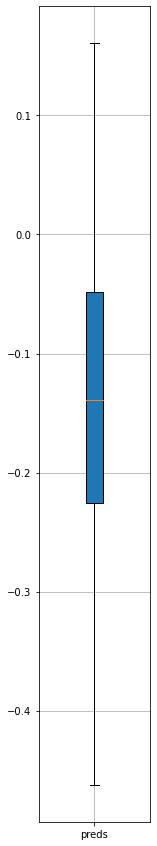

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,15))
plt.grid()
B = plt.boxplot(err[:,0],
                vert=True,  # vertical box alignment
                patch_artist=True,
               labels = ['preds'])

ValueError: Dimensions of labels and X must be compatible

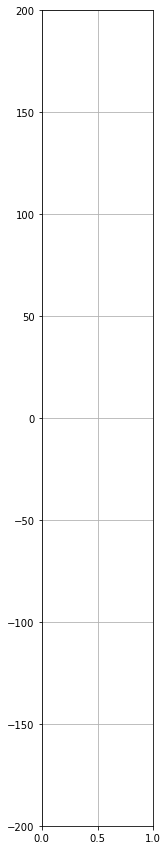

In [322]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,15))
plt.ylim(bottom=-200,top=200)
plt.grid()
B = plt.boxplot(error_per_bands,
                vert=True,  # vertical box alignment
                patch_artist=True,
               labels = ['preds'])

#### 5. Compute error on mean results

In [34]:
res_arr_mean = np.empty(len(preds_df_mean))
for i,col in enumerate(preds_df_mean.columns):
    preds_arr = np.vstack(preds_df_mean[str(col)].values)
    target_arr = np.vstack(len(preds_arr)*[(target_df_mean[str(col)].t60)])
    res_arr_mean[i] = mean_absolute_error(target_arr,preds_arr)
res_arr_mean.mean()


0.44096821172816647

#### 6. Compute error percent

In [64]:
preds_df_mean

,h066_MITCampus_StudentLounge_2txts,h073_MITCampus_StudentLounge_2txts,h175_ParkingLot_1txts,LittlefieldLobby,h171_Outside_BikePath_1txts,PacificHall,TijuanaAqueductTunnel,h062_Campground_Dininghall_3txts,RacquetballCourt,h096_Hotel_Ballroom_2txts,...,h270_Hallway_House_1txts,h206_Outside_Forest_1txts,HartwellTavern,h263_Outside_StreetsOfCambridge_1txts,york-guildhall-councilchamber_s2_r3_ir_1_96000,lady-chapel-st-albans-cathedral,h136_SamdwichShop_1txts,h058_Campground_Dininghall_3txts,CastilloDeLosTresReyesDelMorroSalasDeExposicion,PabstBrewery
speech-us-gov-0233.pkl,0.421532,0.525677,0.120117,1.58031,0.335015,1.07933,1.29975,0.273245,1.16683,0.22355,...,0.261622,0.256751,0.382017,0.143107,1.00141,1.16322,0.34015,0.421816,1.45428,0.366855
speech-librivox-0005.pkl,0.445677,0.762925,0.320085,1.80709,0.412399,0.532076,1.83219,0.595504,1.86024,0.364096,...,0.570685,0.488169,0.4642,0.314424,1.06678,1.84445,0.366082,0.553102,1.89435,0.449616
speech-librivox-0149.pkl,0.316756,0.520252,0.291705,1.68555,0.34926,0.683185,1.24036,0.317697,1.6883,0.288971,...,0.364947,0.3178,0.447076,0.313121,0.495904,1.10813,0.367455,0.453361,1.22144,0.38368
speech-us-gov-0079.pkl,0.362691,0.575186,0.340971,1.48277,0.48166,0.309561,1.05828,0.386624,1.33392,0.219466,...,0.453622,0.285492,0.398472,0.437633,0.649086,0.985602,0.365511,0.417139,0.960365,0.414901
speech-librivox-0150.pkl,0.382135,0.70923,0.37468,1.63231,0.515718,0.572114,0.881145,0.662293,1.20223,0.394978,...,0.435986,0.514198,0.361671,0.548809,0.608054,1.48002,0.434493,0.600069,1.10892,0.532358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
speech-librivox-0029.pkl,0.365881,0.733252,0.157451,1.43692,0.245079,0.812735,1.54005,0.191209,1.36673,0.248466,...,0.513048,0.242929,0.517669,0.218825,0.814563,1.22381,0.24701,0.488947,1.53911,0.60303
speech-us-gov-0132.pkl,0.218373,0.367244,0.181762,1.4537,0.174627,0.17718,0.951818,0.161474,1.3224,0.1229,...,0.224586,0.202302,0.195234,0.16782,1.05914,1.01181,0.125982,0.273217,1.09111,0.112153
speech-librivox-0147.pkl,0.551056,0.649256,0.37366,1.45642,0.383911,0.633471,1.30993,0.460834,1.50918,0.466905,...,0.728971,0.416472,0.379216,0.342133,1.06303,1.31944,0.486031,0.411903,1.14617,0.374273
speech-us-gov-0172.pkl,0.490476,0.559835,0.315212,1.23695,0.324557,0.51719,1.32834,0.367986,1.33192,0.272682,...,0.959834,0.443471,0.526785,0.291761,0.67613,1.12206,0.371919,0.580519,1.16446,0.557888


In [50]:
def compute_error_percent(param,size):
    error = np.empty(size)
    error_abs = np.empty(size)

    for i in range(size):
        error_abs[i] = 100*abs((target_df_mean.T.eval(param)[i]-preds_df_mean.mean()[i])/target_df_mean.T.eval(param)[i])
        error[i] = 100*(target_df_mean.T.eval(param)[i]-preds_df_mean.mean()[i])/target_df_mean.T.eval(param)[i]
    return (error)

In [43]:
error = compute_error_percent('t60',100)
print(error)

[-1.67580818e+01  2.12454717e+01 -1.61390588e+02  5.28048458e+01
 -2.10766686e+02  4.21311421e+01  1.14328660e+01  2.90738500e+01
  4.88181764e+01  2.27552921e+01  4.40380943e+01  4.59540486e+01
  3.82372639e+01 -1.84739546e+01 -1.77817758e+01  6.97293837e+01
  6.62968677e+01 -1.85430052e+00 -1.40616882e+02  1.31239895e+01
  7.53670672e+01  4.41772042e+01  2.30030975e+01  4.75617967e+01
 -2.87683074e+02  3.60511184e+00  7.49505713e+01  1.91133673e+01
 -2.08295910e+01  3.40362582e+01 -2.19747129e+01  1.13733674e+01
 -5.96934857e+02  3.95866214e+01 -6.16031766e+01  3.12426711e+01
 -5.65058990e+02 -1.04824276e+02 -1.39422408e+02  3.54124451e+01
  5.71549463e+01 -5.17064910e+01  1.92155436e+00  9.54284937e+00
  5.92898149e+01  5.52108626e-01 -9.33296313e-02  6.23974142e+00
 -1.14243598e+01  8.43692909e+00 -6.78621627e+01  7.52600603e+01
 -2.20797832e+01 -1.07278433e+01  2.00592250e+01  4.49230918e+01
  3.43707189e+01  5.65174362e+01 -4.76648529e+02 -4.17842981e+02
  4.13307423e+01  5.58604

In [116]:
def compute_error(param,size):
    error = np.empty(size)
    for i in range(size):
        error[i] = target_df_ace.T.eval(param)[i]-preds_df_mean.mean()[i]
    return(error)

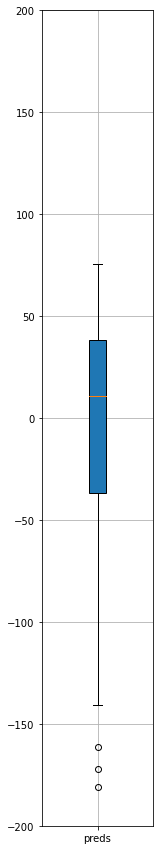

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,15))
plt.ylim(bottom=-200,top=200)
plt.grid()
B = plt.boxplot(error,
                vert=True,  # vertical box alignment
                patch_artist=True,
               labels = ['preds'])

In [58]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [61]:
get_box_plot_data(['error'],B)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,error,-37.212523,-23.744947,-6.358777,9.415293,24.597802


## Garbage

In [9]:

dataset_folder = output_folder

output_size = 13
bands = acoustics.bands.third(500,8000)
#room_folder = dataset_folder + 'X/'


In [25]:
def plot_room_prediction(room_preds,room_name,track_names):
    bands = [125.,  250.,  500., 1000., 2000., 4000.]#acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    for track in room_preds:
        plt.plot(bands, track) 
    plt.legend((track_names))
    plt.show(fig)

In [11]:
def plot_mean_prediction_vs_true(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    plt.plot(bands, mean_preds) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','mean predicted RT60']))
    plt.show(fig)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
def boxplot_room_prediction(room_preds,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    
    plt.boxplot(room_preds[:,:],labels = bands)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [14]:
def boxplot_room_prediction_test(room_preds,room_true,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    plt.xscale('log')
    plt.plot(bands, room_true) 
    fig.suptitle(room_name, fontsize=20)
    
    plt.ylim(bottom=0,top=1.5)
    locs, labels = plt.xticks()
    plt.boxplot(room_preds[:,:],positions = bands)
    plt.xticks(locs)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [15]:
def plot_mean_prediction_vs_true_errbar(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    print(len(room_preds[0]))
    
    error = []
    for i in range(len(room_preds[0])):
        #print(room_preds[i,:])
        quantiles = np.percentile(room_preds[i,:], [25,75])
        quantiles = [np.mean(room_preds[i]) - quantiles[0], quantiles[1] - np.mean(room_preds[i])]
        error.append(quantiles)
        
    error = np.array(error).T
    print(f'error ; {error} \n shape : {error.shape}')
    #print(len(error[1]))
    plt.errorbar(bands,  mean_preds,yerr=error,capsize=10) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','predicted RT60']))
    plt.show(fig)

In [ ]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    #print(f'roomfolder : {room_folder_num}')
    
    #print(rir_folder)
    rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

In [ ]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    print(f'roomfolder : {room_folder_num}')
    
    #print(room_name)
    #rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    #true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    #plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

In [1]:
%cd ..

/home/pcallens/music-parameters-estimation


In [2]:
import pandas as pd

test = pd.read_csv('predictions.csv',index_col=0)

In [14]:
test.iloc[1,1]

'[[3.4497247 3.3226511 2.9863362 2.8020828 2.5715122 2.4585242]]'